# Objectives


 
 1. Alpha investing
 





In [77]:
# First we start loading our favourite packages with the names we used to
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [78]:
# import market factor
url = "https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1"
Factors = pd.read_csv(url,index_col=0, 
                         parse_dates=True,na_values=-99)
Factors=Factors
# keep only market and RF
Factors=Factors.iloc[:,0:2]


# import BEME (Book-equity over Market equity) sorted portfolios
# BEME 1 has low book to market- > Known as growth stocks (example: Tesla, Amazon, Facebook)

# BEME 10 has high book to market -> Known as value stocks ( old firms: utilities, banks, insurance companies)

# but it changes....

url = "https://www.dropbox.com/s/gds8ho9rt1imw03/Valueportfolios.csv?dl=1"
parser = lambda date: pd.to_datetime(date,format='%Y%m')
Data = pd.read_csv(url,index_col=0, 
                         parse_dates=True,date_parser=parser,skiprows=23,nrows=1092,na_values=-99.99)
Data=Data
print(Data.tail())
# neeed to adjsut the date to end of month convention (Even thugh both returns for a given month are end-of-month to end of month,
# when we importer the value portfolios python used as date the first day of the month . To fix that, we will convert it to end of month
# It is important to do that before the merge. Why? )
Data.index=Data.index+pd.tseries.offsets.MonthEnd()
print(Data.head())
# ready to merge with Market and RF

Data=pd.merge(Data,Factors,left_index=True,right_index=True)

# transform in excess returns
Data=Data.subtract(Data['RF'],axis=0)
Data=Data.drop(['RF'],axis=1)

def TSregression(df,beg,end):
    df=df[beg:end] 
    E=pd.DataFrame(df.mean())
    E.columns=['AvgReturns']
    x= sm.add_constant(df['MKT'])
    E['std']=df.std()
    E['alpha']=E['AvgReturns']*0
    E['std_e']=E['AvgReturns']*0
    E['beta']=E['AvgReturns']*0
    E['std_beta']=E['AvgReturns']*0
    E['std_alpha']=E['AvgReturns']*0
    for portfolios in E.index[0:10]:
        y= df[portfolios]
        results= sm.OLS(y,x).fit()
        E.at[portfolios,'alpha']=results.params[0]
        E.at[portfolios,'beta']=results.params[1]
        E.at[portfolios,'std_e']=results.resid.std()
        E.at[portfolios,'std_alpha']=results.HC0_se[0]
        E.at[portfolios,'std_beta']=results.HC0_se[1]          
        E.at[portfolios,'pvalues']=results.pvalues[0] 
    
    E['t-stat']=E['alpha']/E['std_alpha']
    E.at['MKT','beta']=1 
    return E

            BEME1  BEME2  BEME3  BEME4  BEME5  BEME6  BEME7  BEME8  BEME9  \
2017-02-01   4.29   5.22   3.52   2.47   3.90   0.96   2.03   3.24   3.38   
2017-03-01   0.97   2.04   0.30   0.31   0.07  -0.70  -0.99  -1.22  -3.09   
2017-04-01   2.44   1.32   2.16   1.39   2.43  -0.52  -0.44  -0.56  -0.64   
2017-05-01   2.59   2.86   3.10  -0.23   1.29  -0.33  -1.26  -0.70  -2.44   
2017-06-01   0.29  -0.47   0.25   1.15  -0.69   1.21   1.67   2.57   4.31   

            BEME10  
2017-02-01    5.03  
2017-03-01   -2.28  
2017-04-01   -0.86  
2017-05-01   -2.68  
2017-06-01    5.70  
            BEME1  BEME2  BEME3  BEME4  BEME5  BEME6  BEME7  BEME8  BEME9  \
1926-07-31   4.63   1.24  11.40   1.68   1.50   2.09   2.73   1.58   0.63   
1926-08-31   0.15   2.18   6.40   2.38   1.58   2.63   4.46   4.94   8.31   
1926-09-30  -0.11  -2.30   6.32   0.73  -0.89   0.38  -0.28   0.17  -2.16   
1926-10-31  -3.78  -1.63  -5.01  -1.41  -2.31  -2.10  -4.65  -2.80  -5.46   
1926-11-30   6.03   1.49  

In [79]:
TSresults=TSregression(Data,beg='1963',end='2016')
TSresults

,AvgReturns,std,alpha,std_e,beta,std_beta,std_alpha,pvalues,t-stat
BEME1,0.429151,5.044204,-0.123712,1.869759,1.061466,0.020843,0.074220,0.095136,-1.666833
BEME2,0.541836,4.623143,0.020034,1.349928,1.001831,0.015999,0.054048,0.707869,0.370668
BEME3,0.582701,4.581242,0.067784,1.396153,0.988611,0.016216,0.055828,0.220489,1.214158
BEME4,0.538225,4.619711,0.029787,1.667100,0.976173,0.021867,0.066858,0.651893,0.445523
BEME5,0.549583,4.432885,0.073302,1.833515,0.914432,0.021350,0.072508,0.312923,1.010958
BEME6,0.679460,4.343083,0.221188,1.944793,0.879855,0.023928,0.078129,0.004200,2.831076
BEME7,0.641960,4.567017,0.164307,2.115416,0.917066,0.031421,0.086505,0.050189,1.899401
BEME8,0.721574,4.626414,0.245044,2.257864,0.914911,0.032353,0.093092,0.006285,2.632271
BEME9,0.882006,4.939907,0.371075,2.378602,0.980958,0.030973,0.094467,0.000090,3.928115
BEME10,0.937114,6.087765,0.345374,3.452185,1.136108,0.045348,0.135874,0.011735,2.541878


# Alpha Investing



1. Tracking portfolios
2. Hedged portfolio or portable alpha portfolio
3. Appraisal ratio can be recovered from the t-stat
4. Optimal portfolio combination of alpha and market




In [7]:
TSresults

,AvgReturns,std,alpha,std_e,beta,std_beta,std_alpha,pvalues,t-stat
BEME1,0.429151,5.044204,-0.123712,1.869759,1.061466,0.020843,0.074220,0.095136,-1.666833
BEME2,0.541836,4.623143,0.020034,1.349928,1.001831,0.015999,0.054048,0.707869,0.370668
BEME3,0.582701,4.581242,0.067784,1.396153,0.988611,0.016216,0.055828,0.220489,1.214158
BEME4,0.538225,4.619711,0.029787,1.667100,0.976173,0.021867,0.066858,0.651893,0.445523
BEME5,0.549583,4.432885,0.073302,1.833515,0.914432,0.021350,0.072508,0.312923,1.010958
BEME6,0.679460,4.343083,0.221188,1.944793,0.879855,0.023928,0.078129,0.004200,2.831076
BEME7,0.641960,4.567017,0.164307,2.115416,0.917066,0.031421,0.086505,0.050189,1.899401
BEME8,0.721574,4.626414,0.245044,2.257864,0.914911,0.032353,0.093092,0.006285,2.632271
BEME9,0.882006,4.939907,0.371075,2.378602,0.980958,0.030973,0.094467,0.000090,3.928115
BEME10,0.937114,6.087765,0.345374,3.452185,1.136108,0.045348,0.135874,0.011735,2.541878


### Tracking portfolios

Are the portfolios that use a set of factors to track the returns on an asset.

It can be used as way to construct hedges for corporations, hedges for trading strategies, or ways to define a benchmark for an active management.

It is used to construct what people in the industry calls "portable alpha", because it allows one to separate the alpha of the factor exposure of a trading strategy

The idea of the tracking portoflio is to track the component of an asset return that can be obtained by investing in a simple traded factor. For now, this means the market portfolio

How to do it?

For a given trading strategy consider the following relation

$$R^e_i=\alpha_i+\beta_iR^{MKT}+\epsilon_i, $$

with $var(\epsilon_i)=\sigma_e^2$

the i Tracking portfolio is $\beta_iW^{MKT}$, where $W^{MKT}$ is the vector of weights of the market portfolio.

of if one is trading directly on the total market portfolio as an asset, the tracking portfolio weight on the market portfolio asset is simply $\beta_i$


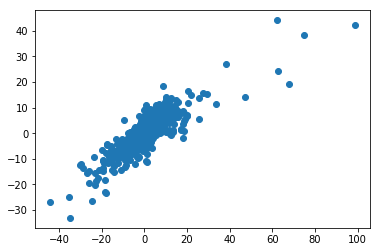

In [86]:
# Returns on the tracking portfolio

Tracking=Data['MKT']*TSresults.loc['BEME10','beta']


# (Tracking/100+1).cumprod().plot()
# (Data['BEME10']/100+1).cumprod().plot()

plt.scatter(x=Data['BEME10'],y=Tracking)

2.The Hedged strategy return is (also called portable alpha)

$$R^{hedged}_i=R^e_i-\beta_iR^{MKT}$$

where this portoflio can be constructed simply by $W^i-\beta^iW^{MKT}$, the weights of the trading strategy minus the tracking portfolio weights. Thik of the excess returns taking out risk-free rate effects and the hedged portfolio taking out market factor effects

a few observations

- the mean return of the hedge portfolios is just the Time series alpha!

- the vol of the strategy is the vol of the residuals of the Time series regression

- If you run a regression on the market you will see that the hedged portfolios have $\beta=0$. This is by construction That is the reason sometimes people call these portfolios "Pure alpha" or a Bridgwater calls it, "Portable alpha"

- By construction, becuase we hedged market risk, The entire SR is enhancing the MV frontier relative to the CAPM


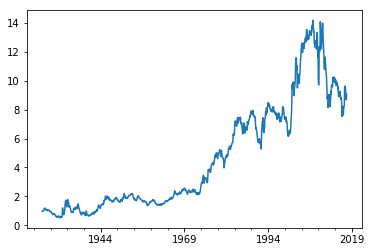

In [87]:
# Returns on the hedged portfolio
# portfolio - tracking portfoloio

Hedged=Data['BEME10']-Tracking
(Hedged/100+1).cumprod().plot()

In [27]:
Hedged['1963':'2016'].mean()

0.34537384159075096

3.Appraisal is the sharpe ratio on the hedged portfolio

$$Appraisal=\alpha_i/\sigma_i=E[R^{Hedged}]/\sigma(R^{Hedged})$$



In [88]:
# Aprraisal ratio is the sharpe ratio of hedged portfolio

# sharpe ratio of the asset after you purge of market exposure

print(Hedged['1963':'2016'].mean()/Hedged['1963':'2016'].std())

print(TSresults.loc['BEME10','alpha']/TSresults.loc['BEME10','std_e'])

0.10004499152314456
0.10004499152314464


There is a tight link between t-stats of time-series regressions and appraisal ratios

$$Appraisal=\alpha_i/\sigma_i$$

Note that $\sigma(\alpha)=\sigma(\epsilon_i)/\sqrt{T}$, therefore

$$Appraisal=\frac{\alpha_i}{\sigma(\alpha)\sqrt{T}}=\frac{T_{stat}}{\sqrt{T}}$$

In [89]:
# link with t-statistic


print(Hedged['1963':'2016'].mean()/Hedged['1963':'2016'].std())

print((TSresults.loc['BEME10','alpha']/TSresults.loc['BEME10','std_alpha'])/Data['1963':'2016'].shape[0]**0.5)

0.10004499152314456
0.09985438132144955



4.Optimal portfolio combination of alpha and market


- How to optimally combine the Hedged portfolio with the Market?

- Recall our formula for the tangency portfolio weights derived in Lecture 3.

$$W^*\propto Var(R^e)^{-1}E[R^e]$$

- now this becomes really simple because the covariance of the new Hedged-MVE strategy is zero with the market


$$Var(R^e)=\left[\begin{array}{cc} \sigma^2(R_{MKT}^e) & 0\\0 & \sigma^2(R_{Hedged,i})\end{array}\right]$$



- So the optimal weights are just

$$W^* \propto \left[\begin{array}{c} \frac{E[R^e_{MKT}]}{\sigma^2(R_{MKT}^e)} \\ \frac{\alpha}{\sigma^2(R_{Hedged,i})}\end{array}\right]$$


- You invest in each strategy according to the strengh of the risk-return trade-off in the strategy

- The symbol $\propto$ means that you have to invest proportionally

- But how much you invest overall will depend on how much risk you want to take





In [91]:
# optimal combination

W=np.array([Data['1963':'2016'].MKT.mean()/Data['1963':'2016'].MKT.std()**2,\
            Hedged['1963':'2016'].mean()/Hedged['1963':'2016'].std()**2])
W/W.sum()

array([0.47987896, 0.52012104])

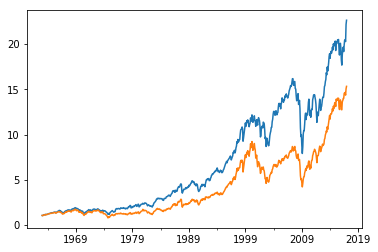

In [92]:
# construc optimal portfolio levered to have the same vol as the market. Compare against the market

Optimalportfolio=W[0]*Data['MKT']+W[1]*Data['BEME10']
Optimalportfolio=Optimalportfolio*Data.MKT.std()/Optimalportfolio.std()
(Optimalportfolio['1963':'2016']/100+1).cumprod().plot()
(Data.MKT['1963':'2016']/100+1).cumprod().plot()


5. How high a SR you get in the end?

  - You can compute your final SR by brute force. Simply computing the SR of the new portfolio.
  - Or more cleverly, you can find the resulting SR of optimally combining any two strategies that are ORTHOGONAL to each other as follows


$$SR_{final}=\sqrt{SR_{MKT}^2+SR_{Hedged}^2}$$

  - This is very general and  can be used any time you run time-series test.

In [69]:
# final SR
# empirical
print(Optimalportfolio['1963':'2016'].mean()/Optimalportfolio['1963':'2016'].std())
# analytical formula

((Data['1963':'2016'].MKT.mean()/Data['1963':'2016'].MKT.std())**2\
+(Hedged['1963':'2016'].mean()/Hedged['1963':'2016'].std())**2)**0.5


0.14584865961163107


0.1547108353463625

### A very neat trick: How to go from regression Tables to Final Sharpe Ratios

Inputs
- SR on the factor (market)
- t-stat on the alpha of a particular strategy on the factor
- T= total number of time-periods

- That is you run
$$R^e_i=\alpha_i+\beta_iR^{MKT}+\epsilon_i$$

Once you have the t-stat on the alpha, this gives you the SR on the hedged strategy once you divide by $\sqrt{T}$, i.e. we have that

$$SR(R^{Hedged})=t(\alpha)/\sqrt{T}$$

- using our fromula above the SR of the optimal portfolio combination can be written as


$$SR_{final}=\sqrt{SR(R^{MKT})^2+SR(R^{Hedged})^2}$$

$$SR_{final}=\sqrt{SR(R^{MKT})^2+(\alpha/\sigma(\epsilon))^2}$$

$$SR_{final}=\sqrt{SR(R^{MKT})^2+(t(\alpha)/\sqrt{T})^2}$$



- This gives you a powerfull way to evaluate whether a given anomally meaningfully expand the investment opportunity set

- Recall that a 10% increase in SR means you can either earn 10% higher return while bearing the same vol or get the same return while bearing 10% less vol

# Data mining considerations.

You have data up to October/2018 and want to hedge market exposure on your trading strategy in the month of November/2018

You run a time-series regression using the entire sample and find your strategy had a beta of 0.7

Does shorting 0.7*market portfolio guarantee that your strategy will have zero beta in the month of november?



